In [64]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn import metrics
from scipy import interpolate
from tqdm import tqdm
from pathlib import Path
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import copy

In [90]:
# Set up plotting style

sns.set(font_scale=1.5)
sns.set_style('ticks')

colors = ['#88CCEE', '#882255', '#999933', '#332288', '#DDCC77', '#117733','#CC6677', '#44AA99', '#AA4499', '#DDDDDD', '#C70039', '#000000', '#D55E00', '#0072B2']

## Data loading and preprocessing

In [47]:
# Load data and filter for minimum number of occurences
# Returns a dict: extinction name -> pandas data frame

min_occurrence = 3

# Cleaned data - three extinctions
data_base = Path('data')

# List of characteristics
characteristics = ['tiering', 'motility', 'feeding', 'protein', 'reproduction', 'mineralogy', 'physiology', 'geoplates', 'species']

# Loading
events = [x for x in data_base.iterdir() if x.is_file() and x.suffix == '.csv']
datasets = {x.name[:x.name.find('_')]: pd.read_csv(x) for x in events}

# Filtering for number of occurrences
datasets = {key: val[val['t_occurrences'] >= min_occurrence] for key, val in datasets.items()}

In [48]:
# Order of the three major extinctions
ext_order = ['PTr', 'TrJ', 'KPg']

In [50]:
# homogenize spelling (capitalization)
for dataset in datasets.values():
    dataset.loc[dataset["mineralogy"] == "High Mg calcite", "mineralogy"] = "high Mg calcite"

In [51]:
# Resamples the data sets to split entries with multiple values into multiple rows with lower weight

def traverse(row, chars, params, weight):
    # Goes over the row recursively and splits if it finds multiple values for one characteristic
    if len(chars) == 0:
        params['weight'] = weight
        return [params]
    else:
        c = chars[0]
        v = row[c]
        if isinstance(v, int) or isinstance(v, float):
            if v < 10:
                params[c] = v
                return traverse(row, chars[1:], params, weight)
            else:
                res = []
                params1 = copy.deepcopy(params)
                params1[c] = v // 10
                res += traverse(row, chars[1:], params1, weight / 2)
                params2 = copy.deepcopy(params)
                params2[c] = v % 10
                res += traverse(row, chars[1:], params2, weight / 2)
                return res
        else:
            res = []
            parts = v.split('/')
                
            for subv in parts:
                subv = subv.strip()
                subparams = copy.deepcopy(params)
                subparams[c] = subv
                res += traverse(row, chars[1:], subparams, weight / len(parts))
            return res

def rewrite_multi_category(dataset):
    # Iterates over the rows for the traversal
    res = []
    for _, row in dataset.iterrows():
        start_cols = [x for x in dataset.columns if x not in characteristics]
        params = {x: row[x] for x in start_cols}
        
        res += traverse(row, characteristics, params, 1)
    
    return pd.DataFrame(res)

def repeat_rows(dataset):
    # Repeat rows according to the inverse of their weights
    wmin = np.min(dataset['weight'])
    res = []
    for _, row in dataset.iterrows():
        res += int(np.round(row['weight'] / wmin)) * [row]
    return pd.DataFrame(res)

# Run the actual resampling
datasets = {k: rewrite_multi_category(v) for k, v in datasets.items()}

In [94]:
orders = {}

# Fixed orders
orders["tiering"] = ["pelagic", "erect", "epifaunal", "semi-infaunal", "shallow infaunal", "deep infaunal"]
orders["motility"] = ["fast, motile", "slow, motile", "facultative, unattached", "facultative, attached", "stationary, unattached", "stationary, attached"]
orders["feeding"] = ["suspension", "surface deposit", "miner", "grazer", "predator", "symbionts"]
orders["protein"] = ['hemerythrin', 'hemocyanin', 'hemoglobin', 'other']
orders["reproduction"] = ['non-broadcaster', 'intermediate', 'broadcaster']
orders["mineralogy"] = ['aragonite', 'high Mg calcite', 'low Mg calcite', 'bimineralic', 'phosphatic', 'chitin', 'gorgonin', 'silica', 'soft-bodied']
orders["physiology"] = ['heavy carbonate load', 'moderate carbonate load', 'little or no carbonate load']

In [82]:
extinctions = ext_order
n_ext = len(extinctions)

## Data exploration

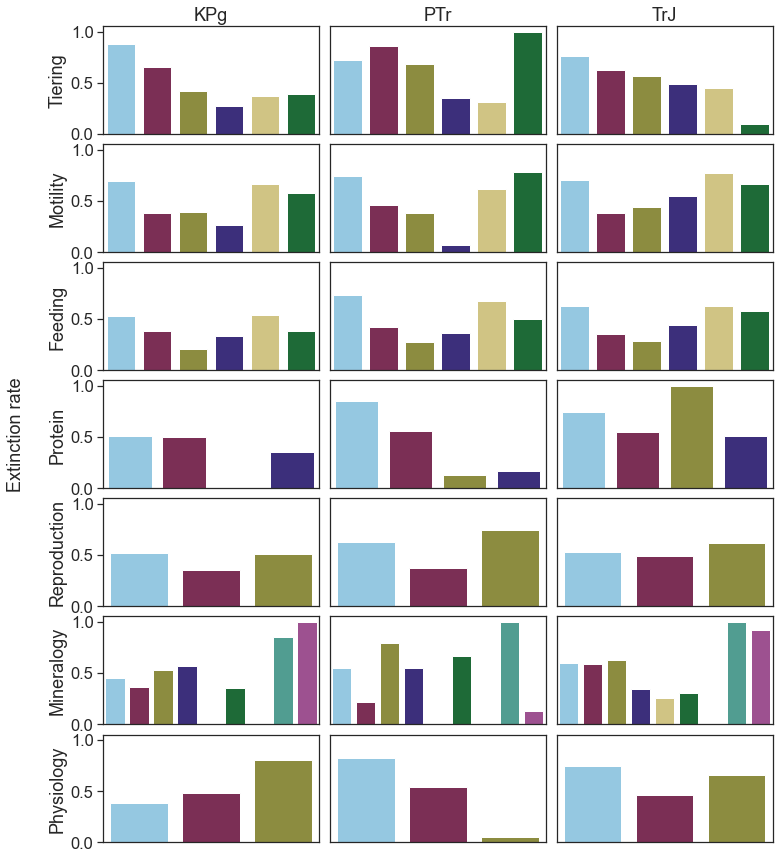

In [106]:
# Exploratory plot of the feature distribution
# For space constraints the feature names are removed

fig = plt.figure(figsize=(12, 15))
axs = fig.subplots(ncols=len(datasets), nrows=len(characteristics) - 2, gridspec_kw={'hspace': 0.1, 'wspace': 0.05}, sharex='row', sharey=True)

for j, (ext, dataset) in enumerate(datasets.items()):
    axs[0][j].set_title(ext)

    for i, char in enumerate(characteristics[:-2]):
        sns.barplot(data=dataset, x=char, y='extinct', ci=None, palette=colors, order=orders[char], ax=axs[i][j])
        
        if j > 0:
            axs[i][j].yaxis.set_visible(False)
        axs[i][j].xaxis.set_visible(False)
        
for i, char in enumerate(characteristics[:-2]):
    axs[i][0].set_ylabel(char.capitalize())
    
axs[3][0].set_ylabel(f'Extinction rate\n\n{characteristics[3].capitalize()}')

fig.savefig("images/extinction_rates.png", dpi=300, bbox_inches="tight")

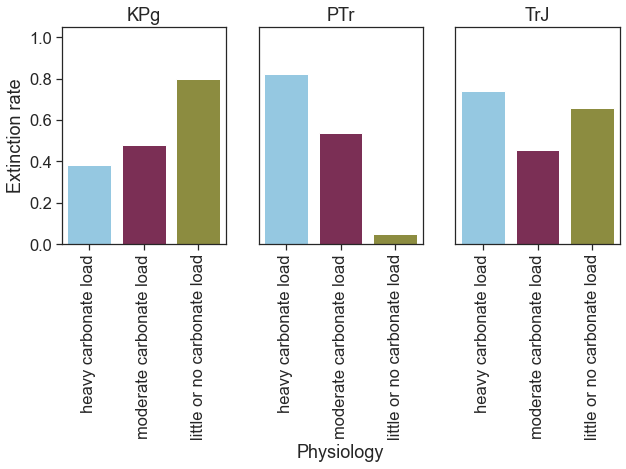

In [96]:
# Exploratory plot for a single characteristic
# char_idx is the index of the char in the list of characteristics
def exploratory_char(char_idx):
    fig = plt.figure(figsize=(10, 4))
    axs = fig.subplots(1, len(datasets), sharex=True, sharey=True)

    for j, (ext, dataset) in enumerate(datasets.items()):
        axs[j].set_title(ext)

        char = characteristics[char_idx]

        sns.barplot(data=dataset, x=char, y='extinct', ci=None, palette=colors, order=orders[char], ax=axs[j])

        if j > 0:
            axs[j].yaxis.set_visible(False)

        axs[j].tick_params(axis='x', rotation=90)
        axs[j].set_xlabel('')

    axs[len(datasets) // 2].set_xlabel(char.capitalize())
    axs[0].set_ylabel('Extinction rate')
    axs[0].set_ylim(0, 1.05)

# Example plot
exploratory_char(6)

In [55]:
# Print dataset statistics for the resampled datasets

print('Extinction\t# Extinct\t# Total\t\tFraction extinct')
for ext in ext_order:
    dataset = datasets[ext]
    print(f'{ext}\t\t{np.sum(dataset["extinct"])}\t\t{len(dataset)}\t\t{np.sum(dataset["extinct"]) / len(dataset):.2f}')

Extinction	# Extinct	# Total		Fraction extinct
PTr		481		721		0.67
TrJ		417		727		0.57
KPg		689		1426		0.48


## E_occurence as predictor

In roughly half of the samples (even more for TrJ) we find e_occurrences < 3. As we required t_occurrences >= 3 in our data selection, this already guarantees for these samples, that they did not went extinct, basically removing half of the data for actuall assessment.

In [23]:
print('Extinction\tNaN\t#e_occurrences < 3\t# Samples')
for name, dataset in datasets.items():
    print(f"{name}\t\t{np.sum(np.isnan(dataset['e_occurrences']))}\t{np.sum(dataset['e_occurrences'] < 3)}\t\t\t{len(dataset)}")

Extinction	NaN	#e_occurrences < 3	# Samples
PTr		0	662			1358
TrJ		0	1512			2632
KPg		4	2254			4944


## Hyperparameter search

In [97]:
# Find optimal hyperparameters 
def find_best_params(training_data, **kwargs):
    model = CatBoostClassifier(iterations=1000)
    
    grid = {'learning_rate': [0.01, 0.03, 0.1, 0.5],
            'depth': [1,4, 6, 8, 10],
            'l2_leaf_reg': [1, 3, 5, 7, 9]}
    
    res_dict = model.grid_search(grid, training_data, verbose=3, **kwargs)
    return res_dict["params"], res_dict["cv_results"]

In [98]:
params = {}
cv_results = {}

for i, base in enumerate(extinctions):
    data = datasets[base]
    x_train, y_train = split_xy(data)
    training_data = Pool(x_train, y_train, 
                         cat_features=np.arange(x_train.shape[1] - 2),
                         weight=data["weight"])
    params[base], cv_results[base] = find_best_params(training_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.4231373618
bestIteration = 997

0:	loss: 0.4231374	best: 0.4231374 (0)	total: 21.5s	remaining: 35m 33s

bestTest = 0.4088341267
bestIteration = 995


bestTest = 0.4065520487
bestIteration = 372


bestTest = 0.4108747247
bestIteration = 86

3:	loss: 0.4108747	best: 0.4065520 (2)	total: 1m 27s	remaining: 34m 59s

bestTest = 0.4214205991
bestIteration = 996


bestTest = 0.4124335672
bestIteration = 991



KeyboardInterrupt: 

## Model training 

In [56]:
def split_xy(data):
    # Returns numpy matrices of features and labels
    return data[characteristics].values, data['extinct'].values

def prepare_data(dataset, split=True):
    if split:
        # Splits data into training and test with a ratio of 80 : 20.
        # Ensures that all samples from the same base index are in the same split to avoid knowledge leaks.
        # Multiple occurrence of the same sample is a result from the resampling.
        base_idx = np.unique(dataset.index)
        
        splits = np.arange(5).repeat(len(base_idx) // 5 + 1)
        np.random.shuffle(splits)
        splits = splits[:len(base_idx)]
        test_idx = base_idx[splits == 0]

        train_data = dataset[~dataset.index.isin(test_idx)]
        test_data = dataset[dataset.index.isin(test_idx)]

        x_train, y_train = split_xy(train_data)
        x_test, y_test = split_xy(test_data)
    
        return x_train, y_train, x_test, y_test
        
    else:
        return split_xy(dataset)

In [57]:
# Train a catboost model
def train_model(x_train, y_train, x_test, y_test, random_seed=0, **kwargs):
    model = CatBoostClassifier(loss_function="Logloss", random_seed=random_seed)

    # Sets all features a categorical except e_occurrences
    model.fit(x_train, y_train, np.arange(x_train.shape[1] - 2), eval_set=(x_test, y_test), **kwargs)
    
    return model

In [107]:
def run_experiments(iterations=10):
    # Trains models and evaluates feature importance and performance on the different data sets for each iteration
    # The results are stored in the variables res_full (AUC scores) and feat_imp (feature importances)

    res_full = np.zeros((iterations, n_ext, n_ext))
    res_full_train = np.zeros((iterations, n_ext))
    feat_imp = np.zeros((iterations, n_ext, len(characteristics)))

    fpr = dict()
    tpr = dict()
    
    data = None
    model = None
    
    for it in tqdm(range(iterations)):
        res = res_full[it]
        res_train = res_full_train[it]
        
        for i, base in enumerate(extinctions):
            data = prepare_data(datasets[base])
                        
            model = train_model(*data, random_seed=it, plot=False, verbose=False, use_best_model=False)

            feat_imp[it, i] = model.feature_importances_

            x_train, y_train, x_test, y_test = data

            train_auc = metrics.roc_auc_score(y_train, model.predict_log_proba(x_train)[:, 1])
            test_auc = metrics.roc_auc_score(y_test, model.predict_log_proba(x_test)[:, 1])
            res_train[i] = train_auc
            res[i, i] = test_auc
            
            fpr[it, base, base], tpr[it, base, base], _ = metrics.roc_curve(
                y_test, model.predict_log_proba(x_test)[:, 1])

            for j, (ext, dataset) in enumerate(datasets.items()):
                if ext == base:
                    continue

                x, y = split_xy(dataset)

                res[i, j] = metrics.roc_auc_score(y, model.predict_log_proba(x)[:, 1])
                fpr[it, base, ext], tpr[it, base, ext], _ = metrics.roc_curve(
                    y, model.predict_log_proba(x)[:, 1])
    
    return res_full, feat_imp, fpr, tpr, res_full_train

In [109]:
res_full_noocc, feat_imp_noocc, fpr_noocc, tpr_noocc, res_train = run_experiments(iterations=2)

100%|██████████| 2/2 [13:49<00:00, 414.58s/it]


In [115]:
# to measure overfitting (dev_score / train_score)
print("dev_score / train_score")
print("\t".join(extinctions))
print("\t".join([f"{x:.2f}" for x in np.mean(res_full_noocc[:, [0, 1, 2], [0, 1, 2]] / res_train, axis=0)]))

dev_score / train_score
PTr	TrJ	KPg
0.71	0.88	0.87


## Result plotting

In [84]:
def plot_auc_grid(res_full, vmax=0.85):
    # Plot average AUC for the different corpora combinations

    fig = plt.figure(figsize=(8, 7))
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, **{'width_ratios': [5, 0.5], 'wspace': 0.1})
    ax = fig.add_subplot(spec[0])

    res_reduced = np.mean(res_full, axis=0)

    cb = ax.imshow(res_reduced, vmin=0.5, vmax=vmax)

    ax.set_xticks(np.arange(n_ext))
    ax.set_xticklabels(extinctions)
    ax.set_yticks(np.arange(n_ext))
    ax.set_yticklabels(extinctions)

    ax.set_xlabel('Applied to')
    ax.set_ylabel('Trained on')

    ax3 = fig.add_subplot(spec[1])
    fig.colorbar(cb, cax=ax3)

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    ax3.set_ylabel('Performance')

In [88]:
def plot_feat_imp(feat_imp):
    # Plot average and standard deviation of the feature importances

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    base_x = np.arange(n_ext)
    w = 0.07

    for i, char in enumerate(characteristics):            
        px = base_x + (i - 3) * w
        m = feat_imp[:, :, i].mean(axis=0)
        std = feat_imp[:, :, i].std(axis=0) / np.sqrt(feat_imp.shape[0])

        ax.plot(px, m, 'o', c=f'C{i}', label=char.capitalize(), ms=10)
        ax.plot(px, m, '-', c=f'C{i}', linewidth=2)
        for j in range(feat_imp.shape[1]):
            ax.plot([px[j], px[j]], [m[j] + std[j], m[j] - std[j]], c=f'k', linewidth=1.5, alpha=1)
            ax.plot([px[j] - w / 3, px[j] + w / 3], [m[j] + std[j], m[j] + std[j]], c=f'k', linewidth=1.5, alpha=1)
            ax.plot([px[j] - w / 3, px[j] + w / 3], [m[j] - std[j], m[j] - std[j]], c=f'k', linewidth=1.5, alpha=1)

    for s, e in zip(base_x[:-1], base_x[1:]):
        ax.axvline((s + e) / 2, alpha=0.3, c='k', linestyle='--', lw=1.5)

    ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
    ax.set_xticks(base_x)
    ax.set_xticklabels(extinctions)

    ax.set_yticklabels([])
    # ax.set_yticks([])
    ax.set_ylabel('Feature importance')
    ax.set_xlabel('Extinction')

In [86]:
def plot_roc_grid(fpr, tpr, res_full):
    res_reduced = np.mean(res_full, axis=0)
    xSpace = np.linspace(0,1,300)

    fig, axs = plt.subplots(3, 3, 
                            sharex=True, sharey=True, 
                            figsize=(12, 12), 
                            gridspec_kw={'hspace': 0.2, 'wspace': 0.15})
    
    for i, ext in enumerate(extinctions):
        for j, base in enumerate(extinctions):
            axs[i, j].set_title(base + r" $\rightarrow$ " + ext)
            interpROCs = []
            for it in range(res_full.shape[0]):
                axs[i, j].plot(fpr[it, base, ext], tpr[it, base, ext], 'k-', alpha=0.3, linewidth=1)
                # ROC curves have different x-values. To average them, they are first interpolated to 
                # a common linspace ("xSpace")
                interpROC = interpolate.interp1d(fpr[it, base, ext], tpr[it, base, ext], kind='linear')
                interpROCs.append(interpROC(xSpace))
                
            avgROC = np.mean(interpROCs, axis=0)
            axs[i, j].plot(xSpace, avgROC, 'k-', alpha=1, linewidth=1)
            axs[i, j].plot([0, 1], [0, 1], "k--")
            axs[i, j].set_xlim(0, 1)
            axs[i, j].set_ylim(0, 1)
            axs[i, j].set_aspect(1)
            axs[i, j].set_xticks([0, 0.5, 1])
            axs[i, j].set_yticks([0, 0.5, 1])
            axs[i, j].set_xticklabels(axs[i, j].get_xticks())
        
            axs[i,j].text(0.4, 0.15, 
                          "$\overline{\mathrm{AUC}}$" + "={:.3f}".format(res_reduced[j,i]), 
                          horizontalalignment="left", 
                          verticalalignment="top")
            
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    
#     plt.show()

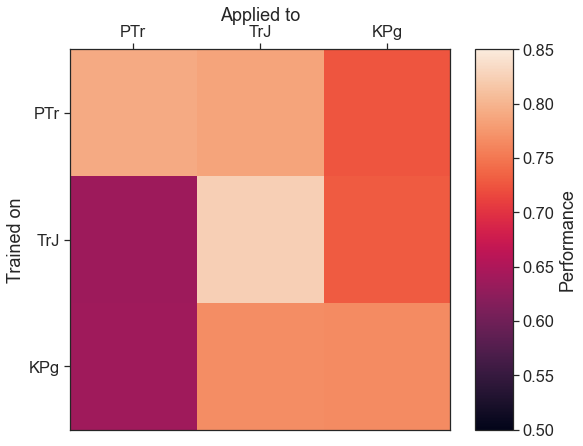

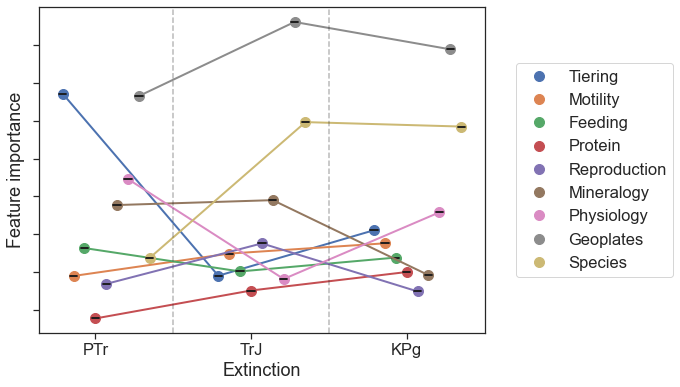

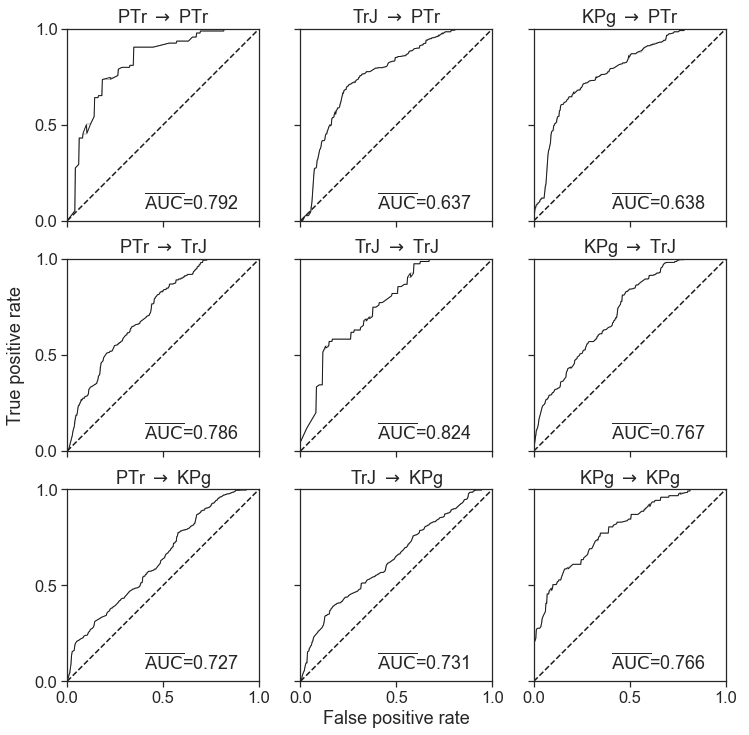

In [89]:
plot_auc_grid(res_full_noocc, vmax=0.85)
plot_feat_imp(feat_imp_noocc)
plot_roc_grid(fpr_noocc, tpr_noocc, res_full_noocc)

## Train and export models for SHAP analysis

In [60]:
# run models on the full dataset, save them for the SHAP code
def run_save_full_models():
    for i, base in enumerate(extinctions):
        data = prepare_data(datasets[base], split = False)

        np.save(f'./data/xtrain{base}.npy', data[0])
        np.save(f'./data/ytrain{base}.npy', data[1])
        
        model = CatBoostClassifier(loss_function="Logloss", random_seed=1)

        # Sets all features as categorical except 'species'
        model.fit(data[0], data[1], cat_features=np.arange(data[0].shape[1] - 2))
  
        model.save_model(f"./models/cgb{base}")


run_save_full_models()

['epifaunal' 'stationary, attached' 'suspension' 'hemocyanin'
 'broadcaster' 'high Mg calcite' 'moderate carbonate load' 1 1.0]
Learning rate set to 0.011988
0:	learn: 0.6913615	total: 215ms	remaining: 3m 34s
1:	learn: 0.6877849	total: 337ms	remaining: 2m 48s
2:	learn: 0.6841211	total: 507ms	remaining: 2m 48s
3:	learn: 0.6813345	total: 662ms	remaining: 2m 44s
4:	learn: 0.6782200	total: 794ms	remaining: 2m 38s
5:	learn: 0.6754880	total: 962ms	remaining: 2m 39s
6:	learn: 0.6727339	total: 1.11s	remaining: 2m 37s
7:	learn: 0.6696563	total: 1.3s	remaining: 2m 40s
8:	learn: 0.6662839	total: 1.52s	remaining: 2m 48s
9:	learn: 0.6636813	total: 1.71s	remaining: 2m 49s
10:	learn: 0.6619313	total: 1.81s	remaining: 2m 43s
11:	learn: 0.6591244	total: 1.98s	remaining: 2m 42s
12:	learn: 0.6568993	total: 2.18s	remaining: 2m 45s
13:	learn: 0.6544308	total: 2.32s	remaining: 2m 43s
14:	learn: 0.6528825	total: 2.46s	remaining: 2m 41s
15:	learn: 0.6505413	total: 2.58s	remaining: 2m 38s
16:	learn: 0.6490213	

155:	learn: 0.5413348	total: 23.5s	remaining: 2m 7s
156:	learn: 0.5411676	total: 23.6s	remaining: 2m 6s
157:	learn: 0.5409251	total: 23.8s	remaining: 2m 6s
158:	learn: 0.5403335	total: 23.9s	remaining: 2m 6s
159:	learn: 0.5400317	total: 24.1s	remaining: 2m 6s
160:	learn: 0.5395468	total: 24.2s	remaining: 2m 6s
161:	learn: 0.5392693	total: 24.4s	remaining: 2m 5s
162:	learn: 0.5391604	total: 24.5s	remaining: 2m 5s
163:	learn: 0.5389028	total: 24.6s	remaining: 2m 5s
164:	learn: 0.5385225	total: 24.7s	remaining: 2m 5s
165:	learn: 0.5380653	total: 24.9s	remaining: 2m 4s
166:	learn: 0.5378531	total: 25s	remaining: 2m 4s
167:	learn: 0.5376973	total: 25.2s	remaining: 2m 4s
168:	learn: 0.5375198	total: 25.4s	remaining: 2m 4s
169:	learn: 0.5373768	total: 25.5s	remaining: 2m 4s
170:	learn: 0.5372372	total: 25.7s	remaining: 2m 4s
171:	learn: 0.5369325	total: 25.8s	remaining: 2m 4s
172:	learn: 0.5368587	total: 25.9s	remaining: 2m 3s
173:	learn: 0.5366226	total: 26.1s	remaining: 2m 3s
174:	learn: 0.

313:	learn: 0.5103208	total: 46.1s	remaining: 1m 40s
314:	learn: 0.5101873	total: 46.2s	remaining: 1m 40s
315:	learn: 0.5099219	total: 46.4s	remaining: 1m 40s
316:	learn: 0.5097890	total: 46.5s	remaining: 1m 40s
317:	learn: 0.5094311	total: 46.7s	remaining: 1m 40s
318:	learn: 0.5093296	total: 46.9s	remaining: 1m 40s
319:	learn: 0.5091915	total: 47s	remaining: 1m 39s
320:	learn: 0.5091167	total: 47.2s	remaining: 1m 39s
321:	learn: 0.5089198	total: 47.3s	remaining: 1m 39s
322:	learn: 0.5087541	total: 47.4s	remaining: 1m 39s
323:	learn: 0.5087012	total: 47.6s	remaining: 1m 39s
324:	learn: 0.5085499	total: 47.7s	remaining: 1m 39s
325:	learn: 0.5082946	total: 47.9s	remaining: 1m 38s
326:	learn: 0.5079942	total: 48s	remaining: 1m 38s
327:	learn: 0.5078749	total: 48.2s	remaining: 1m 38s
328:	learn: 0.5075299	total: 48.3s	remaining: 1m 38s
329:	learn: 0.5075292	total: 48.4s	remaining: 1m 38s
330:	learn: 0.5072111	total: 48.5s	remaining: 1m 38s
331:	learn: 0.5070995	total: 48.7s	remaining: 1m 3

469:	learn: 0.4897051	total: 1m 6s	remaining: 1m 15s
470:	learn: 0.4895573	total: 1m 6s	remaining: 1m 15s
471:	learn: 0.4895081	total: 1m 7s	remaining: 1m 14s
472:	learn: 0.4894028	total: 1m 7s	remaining: 1m 14s
473:	learn: 0.4893503	total: 1m 7s	remaining: 1m 14s
474:	learn: 0.4890982	total: 1m 7s	remaining: 1m 14s
475:	learn: 0.4890423	total: 1m 7s	remaining: 1m 14s
476:	learn: 0.4889409	total: 1m 7s	remaining: 1m 14s
477:	learn: 0.4888792	total: 1m 7s	remaining: 1m 14s
478:	learn: 0.4888221	total: 1m 7s	remaining: 1m 13s
479:	learn: 0.4885585	total: 1m 8s	remaining: 1m 13s
480:	learn: 0.4883645	total: 1m 8s	remaining: 1m 13s
481:	learn: 0.4881781	total: 1m 8s	remaining: 1m 13s
482:	learn: 0.4879219	total: 1m 8s	remaining: 1m 13s
483:	learn: 0.4878150	total: 1m 8s	remaining: 1m 13s
484:	learn: 0.4875694	total: 1m 8s	remaining: 1m 13s
485:	learn: 0.4873995	total: 1m 8s	remaining: 1m 12s
486:	learn: 0.4872687	total: 1m 9s	remaining: 1m 12s
487:	learn: 0.4871055	total: 1m 9s	remaining: 

624:	learn: 0.4726563	total: 1m 26s	remaining: 51.8s
625:	learn: 0.4725404	total: 1m 26s	remaining: 51.7s
626:	learn: 0.4724572	total: 1m 26s	remaining: 51.6s
627:	learn: 0.4722449	total: 1m 26s	remaining: 51.5s
628:	learn: 0.4722449	total: 1m 26s	remaining: 51.3s
629:	learn: 0.4721940	total: 1m 27s	remaining: 51.2s
630:	learn: 0.4721094	total: 1m 27s	remaining: 51s
631:	learn: 0.4719728	total: 1m 27s	remaining: 50.9s
632:	learn: 0.4718993	total: 1m 27s	remaining: 50.8s
633:	learn: 0.4717561	total: 1m 27s	remaining: 50.6s
634:	learn: 0.4716095	total: 1m 27s	remaining: 50.5s
635:	learn: 0.4715174	total: 1m 27s	remaining: 50.3s
636:	learn: 0.4714144	total: 1m 28s	remaining: 50.2s
637:	learn: 0.4713530	total: 1m 28s	remaining: 50s
638:	learn: 0.4712593	total: 1m 28s	remaining: 49.9s
639:	learn: 0.4712115	total: 1m 28s	remaining: 49.8s
640:	learn: 0.4711326	total: 1m 28s	remaining: 49.6s
641:	learn: 0.4710591	total: 1m 28s	remaining: 49.5s
642:	learn: 0.4709181	total: 1m 28s	remaining: 49.

781:	learn: 0.4580673	total: 1m 48s	remaining: 30.3s
782:	learn: 0.4579048	total: 1m 48s	remaining: 30.2s
783:	learn: 0.4578919	total: 1m 48s	remaining: 30s
784:	learn: 0.4578786	total: 1m 49s	remaining: 29.9s
785:	learn: 0.4578358	total: 1m 49s	remaining: 29.7s
786:	learn: 0.4577886	total: 1m 49s	remaining: 29.6s
787:	learn: 0.4576687	total: 1m 49s	remaining: 29.4s
788:	learn: 0.4575207	total: 1m 49s	remaining: 29.3s
789:	learn: 0.4574974	total: 1m 49s	remaining: 29.2s
790:	learn: 0.4574860	total: 1m 49s	remaining: 29s
791:	learn: 0.4574499	total: 1m 49s	remaining: 28.9s
792:	learn: 0.4573642	total: 1m 50s	remaining: 28.8s
793:	learn: 0.4573128	total: 1m 50s	remaining: 28.6s
794:	learn: 0.4571841	total: 1m 50s	remaining: 28.5s
795:	learn: 0.4571001	total: 1m 50s	remaining: 28.3s
796:	learn: 0.4570087	total: 1m 50s	remaining: 28.2s
797:	learn: 0.4569643	total: 1m 50s	remaining: 28.1s
798:	learn: 0.4569458	total: 1m 50s	remaining: 27.9s
799:	learn: 0.4569433	total: 1m 51s	remaining: 27.

939:	learn: 0.4450327	total: 2m 9s	remaining: 8.25s
940:	learn: 0.4449509	total: 2m 9s	remaining: 8.11s
941:	learn: 0.4448803	total: 2m 9s	remaining: 7.97s
942:	learn: 0.4448014	total: 2m 9s	remaining: 7.83s
943:	learn: 0.4445919	total: 2m 9s	remaining: 7.7s
944:	learn: 0.4444656	total: 2m 9s	remaining: 7.56s
945:	learn: 0.4443131	total: 2m 9s	remaining: 7.42s
946:	learn: 0.4442376	total: 2m 10s	remaining: 7.28s
947:	learn: 0.4442241	total: 2m 10s	remaining: 7.14s
948:	learn: 0.4441217	total: 2m 10s	remaining: 7.01s
949:	learn: 0.4440302	total: 2m 10s	remaining: 6.87s
950:	learn: 0.4439764	total: 2m 10s	remaining: 6.73s
951:	learn: 0.4439291	total: 2m 10s	remaining: 6.59s
952:	learn: 0.4438407	total: 2m 10s	remaining: 6.46s
953:	learn: 0.4437756	total: 2m 11s	remaining: 6.32s
954:	learn: 0.4437423	total: 2m 11s	remaining: 6.18s
955:	learn: 0.4437268	total: 2m 11s	remaining: 6.04s
956:	learn: 0.4436856	total: 2m 11s	remaining: 5.9s
957:	learn: 0.4435440	total: 2m 11s	remaining: 5.77s
95

96:	learn: 0.4886012	total: 14.7s	remaining: 2m 17s
97:	learn: 0.4878425	total: 14.9s	remaining: 2m 17s
98:	learn: 0.4868460	total: 15.1s	remaining: 2m 17s
99:	learn: 0.4857811	total: 15.3s	remaining: 2m 17s
100:	learn: 0.4847127	total: 15.4s	remaining: 2m 17s
101:	learn: 0.4833950	total: 15.5s	remaining: 2m 16s
102:	learn: 0.4821846	total: 15.7s	remaining: 2m 16s
103:	learn: 0.4812748	total: 15.8s	remaining: 2m 16s
104:	learn: 0.4799949	total: 16s	remaining: 2m 16s
105:	learn: 0.4788500	total: 16.2s	remaining: 2m 16s
106:	learn: 0.4776696	total: 16.3s	remaining: 2m 15s
107:	learn: 0.4764552	total: 16.5s	remaining: 2m 16s
108:	learn: 0.4759539	total: 16.5s	remaining: 2m 15s
109:	learn: 0.4752965	total: 16.7s	remaining: 2m 14s
110:	learn: 0.4737932	total: 16.9s	remaining: 2m 15s
111:	learn: 0.4729164	total: 17s	remaining: 2m 14s
112:	learn: 0.4720268	total: 17.2s	remaining: 2m 14s
113:	learn: 0.4711163	total: 17.4s	remaining: 2m 14s
114:	learn: 0.4702057	total: 17.5s	remaining: 2m 14s
1

253:	learn: 0.4075089	total: 35.1s	remaining: 1m 43s
254:	learn: 0.4073366	total: 35.2s	remaining: 1m 42s
255:	learn: 0.4071674	total: 35.3s	remaining: 1m 42s
256:	learn: 0.4069846	total: 35.5s	remaining: 1m 42s
257:	learn: 0.4068151	total: 35.6s	remaining: 1m 42s
258:	learn: 0.4066910	total: 35.7s	remaining: 1m 42s
259:	learn: 0.4062503	total: 35.8s	remaining: 1m 41s
260:	learn: 0.4059879	total: 36s	remaining: 1m 41s
261:	learn: 0.4053344	total: 36.1s	remaining: 1m 41s
262:	learn: 0.4053306	total: 36.1s	remaining: 1m 41s
263:	learn: 0.4050474	total: 36.3s	remaining: 1m 41s
264:	learn: 0.4048907	total: 36.4s	remaining: 1m 40s
265:	learn: 0.4046875	total: 36.4s	remaining: 1m 40s
266:	learn: 0.4044596	total: 36.6s	remaining: 1m 40s
267:	learn: 0.4042409	total: 36.7s	remaining: 1m 40s
268:	learn: 0.4039517	total: 36.9s	remaining: 1m 40s
269:	learn: 0.4037986	total: 37s	remaining: 1m 39s
270:	learn: 0.4036124	total: 37.1s	remaining: 1m 39s
271:	learn: 0.4033600	total: 37.2s	remaining: 1m 3

410:	learn: 0.3785777	total: 54.3s	remaining: 1m 17s
411:	learn: 0.3783783	total: 54.4s	remaining: 1m 17s
412:	learn: 0.3782590	total: 54.5s	remaining: 1m 17s
413:	learn: 0.3782013	total: 54.7s	remaining: 1m 17s
414:	learn: 0.3781248	total: 54.9s	remaining: 1m 17s
415:	learn: 0.3779175	total: 55s	remaining: 1m 17s
416:	learn: 0.3777994	total: 55s	remaining: 1m 16s
417:	learn: 0.3775878	total: 55.3s	remaining: 1m 16s
418:	learn: 0.3774074	total: 55.4s	remaining: 1m 16s
419:	learn: 0.3773250	total: 55.5s	remaining: 1m 16s
420:	learn: 0.3772384	total: 55.6s	remaining: 1m 16s
421:	learn: 0.3771790	total: 55.8s	remaining: 1m 16s
422:	learn: 0.3770139	total: 55.9s	remaining: 1m 16s
423:	learn: 0.3769434	total: 56.1s	remaining: 1m 16s
424:	learn: 0.3768249	total: 56.2s	remaining: 1m 16s
425:	learn: 0.3768131	total: 56.3s	remaining: 1m 15s
426:	learn: 0.3766721	total: 56.4s	remaining: 1m 15s
427:	learn: 0.3765601	total: 56.5s	remaining: 1m 15s
428:	learn: 0.3764755	total: 56.6s	remaining: 1m 1

569:	learn: 0.3600730	total: 1m 14s	remaining: 56s
570:	learn: 0.3600137	total: 1m 14s	remaining: 55.8s
571:	learn: 0.3599969	total: 1m 14s	remaining: 55.7s
572:	learn: 0.3598511	total: 1m 14s	remaining: 55.5s
573:	learn: 0.3597829	total: 1m 14s	remaining: 55.4s
574:	learn: 0.3595773	total: 1m 14s	remaining: 55.3s
575:	learn: 0.3592657	total: 1m 14s	remaining: 55.2s
576:	learn: 0.3592146	total: 1m 15s	remaining: 55.1s
577:	learn: 0.3590691	total: 1m 15s	remaining: 54.9s
578:	learn: 0.3589712	total: 1m 15s	remaining: 54.8s
579:	learn: 0.3587587	total: 1m 15s	remaining: 54.7s
580:	learn: 0.3585912	total: 1m 15s	remaining: 54.5s
581:	learn: 0.3584346	total: 1m 15s	remaining: 54.4s
582:	learn: 0.3583006	total: 1m 15s	remaining: 54.3s
583:	learn: 0.3582054	total: 1m 16s	remaining: 54.2s
584:	learn: 0.3581221	total: 1m 16s	remaining: 54.1s
585:	learn: 0.3581219	total: 1m 16s	remaining: 53.9s
586:	learn: 0.3581102	total: 1m 16s	remaining: 53.7s
587:	learn: 0.3579927	total: 1m 16s	remaining: 5

725:	learn: 0.3433629	total: 1m 34s	remaining: 35.6s
726:	learn: 0.3431007	total: 1m 34s	remaining: 35.4s
727:	learn: 0.3429583	total: 1m 34s	remaining: 35.3s
728:	learn: 0.3428733	total: 1m 34s	remaining: 35.2s
729:	learn: 0.3428385	total: 1m 34s	remaining: 35s
730:	learn: 0.3427271	total: 1m 34s	remaining: 34.9s
731:	learn: 0.3426460	total: 1m 34s	remaining: 34.7s
732:	learn: 0.3424386	total: 1m 35s	remaining: 34.6s
733:	learn: 0.3423665	total: 1m 35s	remaining: 34.5s
734:	learn: 0.3423645	total: 1m 35s	remaining: 34.3s
735:	learn: 0.3423286	total: 1m 35s	remaining: 34.2s
736:	learn: 0.3422162	total: 1m 35s	remaining: 34.1s
737:	learn: 0.3420229	total: 1m 35s	remaining: 33.9s
738:	learn: 0.3417958	total: 1m 35s	remaining: 33.8s
739:	learn: 0.3417452	total: 1m 35s	remaining: 33.6s
740:	learn: 0.3417148	total: 1m 35s	remaining: 33.5s
741:	learn: 0.3416586	total: 1m 35s	remaining: 33.4s
742:	learn: 0.3415453	total: 1m 36s	remaining: 33.2s
743:	learn: 0.3413413	total: 1m 36s	remaining: 3

881:	learn: 0.3297339	total: 1m 52s	remaining: 15.1s
882:	learn: 0.3297339	total: 1m 52s	remaining: 14.9s
883:	learn: 0.3296363	total: 1m 52s	remaining: 14.8s
884:	learn: 0.3295699	total: 1m 53s	remaining: 14.7s
885:	learn: 0.3294973	total: 1m 53s	remaining: 14.6s
886:	learn: 0.3294635	total: 1m 53s	remaining: 14.4s
887:	learn: 0.3293073	total: 1m 53s	remaining: 14.3s
888:	learn: 0.3290042	total: 1m 53s	remaining: 14.2s
889:	learn: 0.3289381	total: 1m 53s	remaining: 14s
890:	learn: 0.3289203	total: 1m 53s	remaining: 13.9s
891:	learn: 0.3288699	total: 1m 53s	remaining: 13.8s
892:	learn: 0.3287583	total: 1m 53s	remaining: 13.6s
893:	learn: 0.3287106	total: 1m 54s	remaining: 13.5s
894:	learn: 0.3287025	total: 1m 54s	remaining: 13.4s
895:	learn: 0.3287024	total: 1m 54s	remaining: 13.3s
896:	learn: 0.3286756	total: 1m 54s	remaining: 13.1s
897:	learn: 0.3285873	total: 1m 54s	remaining: 13s
898:	learn: 0.3285840	total: 1m 54s	remaining: 12.9s
899:	learn: 0.3285482	total: 1m 55s	remaining: 12.

36:	learn: 0.6083905	total: 5.25s	remaining: 2m 16s
37:	learn: 0.6074670	total: 5.4s	remaining: 2m 16s
38:	learn: 0.6054974	total: 5.6s	remaining: 2m 18s
39:	learn: 0.6040313	total: 5.75s	remaining: 2m 17s
40:	learn: 0.6022338	total: 5.94s	remaining: 2m 19s
41:	learn: 0.6000517	total: 6.11s	remaining: 2m 19s
42:	learn: 0.5987658	total: 6.23s	remaining: 2m 18s
43:	learn: 0.5972141	total: 6.4s	remaining: 2m 19s
44:	learn: 0.5959018	total: 6.62s	remaining: 2m 20s
45:	learn: 0.5945367	total: 6.79s	remaining: 2m 20s
46:	learn: 0.5929532	total: 6.94s	remaining: 2m 20s
47:	learn: 0.5911116	total: 7.08s	remaining: 2m 20s
48:	learn: 0.5898581	total: 7.26s	remaining: 2m 20s
49:	learn: 0.5882398	total: 7.39s	remaining: 2m 20s
50:	learn: 0.5863564	total: 7.56s	remaining: 2m 20s
51:	learn: 0.5846665	total: 7.71s	remaining: 2m 20s
52:	learn: 0.5835811	total: 7.85s	remaining: 2m 20s
53:	learn: 0.5820194	total: 8.03s	remaining: 2m 20s
54:	learn: 0.5809475	total: 8.21s	remaining: 2m 21s
55:	learn: 0.58

194:	learn: 0.4903352	total: 25.9s	remaining: 1m 46s
195:	learn: 0.4901320	total: 26s	remaining: 1m 46s
196:	learn: 0.4898713	total: 26.1s	remaining: 1m 46s
197:	learn: 0.4898114	total: 26.2s	remaining: 1m 46s
198:	learn: 0.4894207	total: 26.3s	remaining: 1m 45s
199:	learn: 0.4889782	total: 26.4s	remaining: 1m 45s
200:	learn: 0.4887446	total: 26.6s	remaining: 1m 45s
201:	learn: 0.4885775	total: 26.7s	remaining: 1m 45s
202:	learn: 0.4881690	total: 26.8s	remaining: 1m 45s
203:	learn: 0.4880436	total: 26.9s	remaining: 1m 45s
204:	learn: 0.4877130	total: 27.1s	remaining: 1m 45s
205:	learn: 0.4875175	total: 27.3s	remaining: 1m 45s
206:	learn: 0.4871426	total: 27.4s	remaining: 1m 44s
207:	learn: 0.4867195	total: 27.6s	remaining: 1m 44s
208:	learn: 0.4863702	total: 27.7s	remaining: 1m 44s
209:	learn: 0.4859920	total: 27.8s	remaining: 1m 44s
210:	learn: 0.4856797	total: 28s	remaining: 1m 44s
211:	learn: 0.4852175	total: 28.2s	remaining: 1m 44s
212:	learn: 0.4849363	total: 28.3s	remaining: 1m 4

352:	learn: 0.4537820	total: 45.5s	remaining: 1m 23s
353:	learn: 0.4535706	total: 45.6s	remaining: 1m 23s
354:	learn: 0.4534361	total: 45.7s	remaining: 1m 23s
355:	learn: 0.4529519	total: 45.9s	remaining: 1m 22s
356:	learn: 0.4526164	total: 46s	remaining: 1m 22s
357:	learn: 0.4525671	total: 46s	remaining: 1m 22s
358:	learn: 0.4523847	total: 46.1s	remaining: 1m 22s
359:	learn: 0.4522747	total: 46.2s	remaining: 1m 22s
360:	learn: 0.4521816	total: 46.4s	remaining: 1m 22s
361:	learn: 0.4520792	total: 46.5s	remaining: 1m 21s
362:	learn: 0.4519117	total: 46.6s	remaining: 1m 21s
363:	learn: 0.4517257	total: 46.8s	remaining: 1m 21s
364:	learn: 0.4515602	total: 46.9s	remaining: 1m 21s
365:	learn: 0.4513341	total: 47s	remaining: 1m 21s
366:	learn: 0.4510996	total: 47.2s	remaining: 1m 21s
367:	learn: 0.4507154	total: 47.4s	remaining: 1m 21s
368:	learn: 0.4505798	total: 47.4s	remaining: 1m 21s
369:	learn: 0.4503943	total: 47.6s	remaining: 1m 21s
370:	learn: 0.4503217	total: 47.7s	remaining: 1m 20s

511:	learn: 0.4266144	total: 1m 4s	remaining: 1m 1s
512:	learn: 0.4265069	total: 1m 4s	remaining: 1m 1s
513:	learn: 0.4263387	total: 1m 5s	remaining: 1m 1s
514:	learn: 0.4262721	total: 1m 5s	remaining: 1m 1s
515:	learn: 0.4261478	total: 1m 5s	remaining: 1m 1s
516:	learn: 0.4261131	total: 1m 5s	remaining: 1m 1s
517:	learn: 0.4259295	total: 1m 5s	remaining: 1m
518:	learn: 0.4257648	total: 1m 5s	remaining: 1m
519:	learn: 0.4257097	total: 1m 5s	remaining: 1m
520:	learn: 0.4254594	total: 1m 5s	remaining: 1m
521:	learn: 0.4253522	total: 1m 6s	remaining: 1m
522:	learn: 0.4252430	total: 1m 6s	remaining: 1m
523:	learn: 0.4251029	total: 1m 6s	remaining: 1m
524:	learn: 0.4250241	total: 1m 6s	remaining: 1m
525:	learn: 0.4249869	total: 1m 6s	remaining: 59.9s
526:	learn: 0.4248960	total: 1m 6s	remaining: 59.8s
527:	learn: 0.4248230	total: 1m 6s	remaining: 59.7s
528:	learn: 0.4245819	total: 1m 6s	remaining: 59.6s
529:	learn: 0.4245691	total: 1m 6s	remaining: 59.4s
530:	learn: 0.4243376	total: 1m 7s	r

669:	learn: 0.4037112	total: 1m 23s	remaining: 41.1s
670:	learn: 0.4035878	total: 1m 23s	remaining: 41s
671:	learn: 0.4035014	total: 1m 23s	remaining: 40.9s
672:	learn: 0.4033086	total: 1m 23s	remaining: 40.8s
673:	learn: 0.4031802	total: 1m 23s	remaining: 40.6s
674:	learn: 0.4030789	total: 1m 24s	remaining: 40.5s
675:	learn: 0.4028892	total: 1m 24s	remaining: 40.3s
676:	learn: 0.4027049	total: 1m 24s	remaining: 40.2s
677:	learn: 0.4025282	total: 1m 24s	remaining: 40.1s
678:	learn: 0.4022294	total: 1m 24s	remaining: 39.9s
679:	learn: 0.4020519	total: 1m 24s	remaining: 39.8s
680:	learn: 0.4019537	total: 1m 24s	remaining: 39.7s
681:	learn: 0.4019126	total: 1m 24s	remaining: 39.6s
682:	learn: 0.4018423	total: 1m 25s	remaining: 39.5s
683:	learn: 0.4016892	total: 1m 25s	remaining: 39.3s
684:	learn: 0.4015512	total: 1m 25s	remaining: 39.2s
685:	learn: 0.4014784	total: 1m 25s	remaining: 39.1s
686:	learn: 0.4013678	total: 1m 25s	remaining: 38.9s
687:	learn: 0.4011828	total: 1m 25s	remaining: 3

825:	learn: 0.3828770	total: 1m 41s	remaining: 21.4s
826:	learn: 0.3826188	total: 1m 41s	remaining: 21.3s
827:	learn: 0.3824967	total: 1m 42s	remaining: 21.2s
828:	learn: 0.3824456	total: 1m 42s	remaining: 21.1s
829:	learn: 0.3823467	total: 1m 42s	remaining: 20.9s
830:	learn: 0.3822838	total: 1m 42s	remaining: 20.8s
831:	learn: 0.3821907	total: 1m 42s	remaining: 20.7s
832:	learn: 0.3820969	total: 1m 42s	remaining: 20.6s
833:	learn: 0.3820398	total: 1m 42s	remaining: 20.4s
834:	learn: 0.3819856	total: 1m 42s	remaining: 20.3s
835:	learn: 0.3818113	total: 1m 42s	remaining: 20.2s
836:	learn: 0.3817388	total: 1m 43s	remaining: 20.1s
837:	learn: 0.3814528	total: 1m 43s	remaining: 20s
838:	learn: 0.3814316	total: 1m 43s	remaining: 19.8s
839:	learn: 0.3811228	total: 1m 43s	remaining: 19.7s
840:	learn: 0.3810415	total: 1m 43s	remaining: 19.6s
841:	learn: 0.3810155	total: 1m 43s	remaining: 19.5s
842:	learn: 0.3809108	total: 1m 43s	remaining: 19.3s
843:	learn: 0.3808733	total: 1m 43s	remaining: 1

982:	learn: 0.3631637	total: 2m 1s	remaining: 2.09s
983:	learn: 0.3630714	total: 2m 1s	remaining: 1.97s
984:	learn: 0.3629186	total: 2m 1s	remaining: 1.85s
985:	learn: 0.3627759	total: 2m 1s	remaining: 1.73s
986:	learn: 0.3626254	total: 2m 1s	remaining: 1.6s
987:	learn: 0.3623896	total: 2m 1s	remaining: 1.48s
988:	learn: 0.3622440	total: 2m 1s	remaining: 1.35s
989:	learn: 0.3621879	total: 2m 1s	remaining: 1.23s
990:	learn: 0.3620691	total: 2m 2s	remaining: 1.11s
991:	learn: 0.3620083	total: 2m 2s	remaining: 985ms
992:	learn: 0.3618865	total: 2m 2s	remaining: 862ms
993:	learn: 0.3618386	total: 2m 2s	remaining: 738ms
994:	learn: 0.3616961	total: 2m 2s	remaining: 615ms
995:	learn: 0.3615900	total: 2m 2s	remaining: 492ms
996:	learn: 0.3614658	total: 2m 2s	remaining: 369ms
997:	learn: 0.3613906	total: 2m 2s	remaining: 246ms
998:	learn: 0.3611171	total: 2m 2s	remaining: 123ms
999:	learn: 0.3609125	total: 2m 2s	remaining: 0us


## Number of unique metaspecies

Analyze how many unique metaspecies (ecospaces) exist and which fraction of the samples the most common ones make up

In [104]:
def plot_unique_metaspecies():
    meta_species = []
    for data_name in ext_order:
        dataset = datasets[data_name]
        grouped = dataset.groupby(characteristics)
        group_sizes = grouped.apply(lambda x: np.sum(x["weight"]))
        group_sizes = group_sizes.rename(data_name+"_size")
        grouped_df = pd.DataFrame(group_sizes)
        grouped_df[data_name+"_extProb"] = [np.sum(x['extinct'] * x['weight']) / np.sum(x['weight']) for _, x in grouped]
        meta_species.append(grouped_df)

    meta_species_df = meta_species[0].join(meta_species[1:], how="outer")
    meta_species_df = meta_species_df.sort_values("PTr_size", ascending=False)

    for data_name in ext_order:
        mask = np.isnan(meta_species_df[data_name + "_size"])
        meta_species_df[data_name + "_size"][mask] = 0

    meta_species_df['total_size'] = meta_species_df['PTr_size'] + meta_species_df['TrJ_size'] + meta_species_df['KPg_size']
    meta_species_df.sort_values('total_size', ascending=False, inplace=True)

    fig = plt.figure(figsize=(15, 10))
    axs = fig.subplots(3, 2, gridspec_kw={'hspace': 0, 'wspace': 0.05, 'width_ratios': [10, 0.5]})

    gs = axs[0, -1].get_gridspec()
    for ax in axs[0:, -1]:
        ax.remove()
    ax_cb = fig.add_subplot(gs[0:, -1])

    for i, data_name in enumerate(ext_order):
        ax = axs[i, 0]
        cmap = plt.get_cmap('coolwarm')
        norm = mpl.colors.Normalize(vmin=0,vmax=1)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

        bar_x = np.arange(len(meta_species_df[data_name+"_size"]))
        bars = ax.bar(bar_x, np.array(meta_species_df[data_name+"_size"]))

        for bar, p in zip(bars, np.array(meta_species_df[data_name+"_extProb"])):
            bar.set_color(cmap(p))

        ax.set_xticklabels([])
        ax.set_ylabel(data_name)
        ax.set_xlim(-0.55, 25.55)
        ax.set_xticks([])

    cb = fig.colorbar(sm, cax=ax_cb)
    cb.set_label('Extinction probability')

    axs[2, 0].set_xlabel('Unique samples')
    axs[1, 0].set_ylabel(f'Occurrence of sample\n{ext_order[1]}')
    axs[2, 0].set_ylim(0, 34)

    fig.savefig("images/meta_species_occurrences.png", dpi=300, bbox_inches="tight")

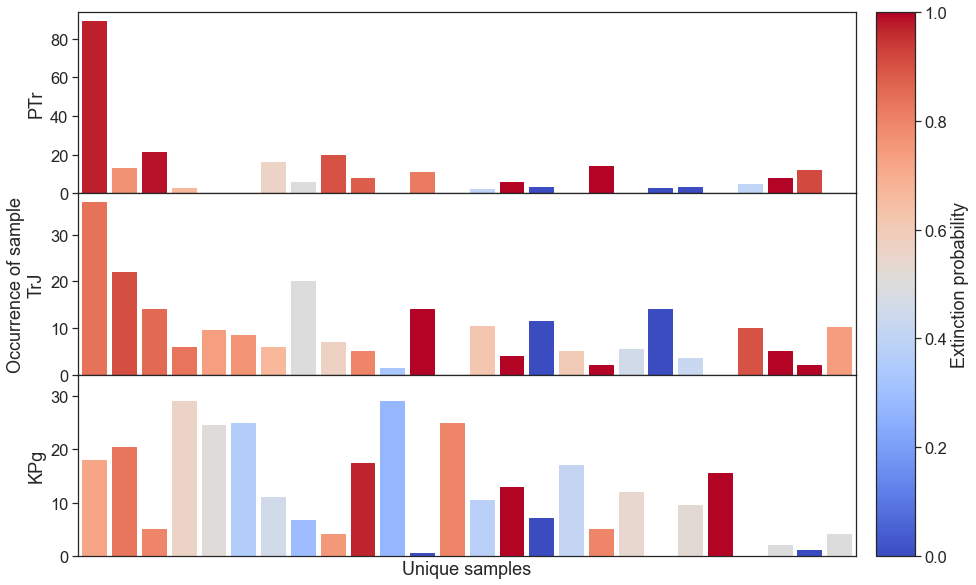

In [105]:
plot_unique_metaspecies()